In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
import operator
import itertools
import matplotlib as mpl
from sklearn import mixture
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_train = pd.read_csv('../data/[UCI] AAAI-14 Accepted Papers - Papers.csv')
data_train = data_train[['title', 'groups', 'keywords', 'topics']]
print(len(data_train))
data_train

398


,title,groups,keywords,topics
0,Kernelized Bayesian Transfer Learning,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...
1,"""Source Free"" Transfer Learning for Text Class...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...
2,A Generalization of Probabilistic Serial to Ra...,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting
3,Lifetime Lexical Variation in Social Media,NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...
4,Hybrid Singular Value Thresholding for Tensor ...,Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...
...,...,...,...,...
393,Mapping Users Across Networks by Manifold Alig...,AI and the Web (AIW),Social Networks\nManifold Alignment\nHypergrap...,AIW: Machine learning and the web\nAIW: Ontolo...
394,Compact Aspect Embedding For Diversified Query...,AI and the Web (AIW),query expansion\nsearch result diversification...,AIW: Enhancing web search and information retr...
395,Contraction and Revision over DL-Lite TBoxes,Knowledge Representation and Reasoning (KRR),Belief Change\nDescription Logic\nNon-monotoni...,KRR: Belief Change\nKRR: Description Logics\nK...
396,Zero Pronoun Resolution as Ranking,NLP and Text Mining (NLPTM),Zero Pronouns\nText Mining\nNatural Language P...,NLPTM: Evaluation and Analysis


### Expand data frame rows as a function of groups.

In [3]:
# Split the contents of the groups column with \n, 
# and arrange them according to only one keyword in each row
s = data_train['groups'].str.split('\n').apply(pd.Series, 1).stack()
# To remove MultiIndex, we need to use droplevel, 
# and use the same label to represent the keywords of the same sample
s.index = s.index.droplevel(-1)
s.name = 'groups'
del data_train['groups']
# Add the constructed column of advanced keywords selected by the author to the data set
data_train = data_train.join(s).reset_index()

In [4]:
data_train['flags'] = pd.Series(np.ones(len(data_train)), index=data_train.index)
data_train.head()

,index,title,keywords,topics,groups,flags
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0


### Create a pivot table, convert the training data into a pivot table with titles as an index, and each group is represented by a separate column.

In [5]:
def matrix_from_df(data_train):
    # Create a pivot table, use the title of the paper as the index of the dataframe, aggregate the groups column (similar to onehot encoding), 
    # and use flags to calculate how many times each keyword in the groups appears.
    matrix = data_train.pivot_table(index=['title'], columns=['groups'], values='flags')
    matrix = matrix.fillna(0).reset_index()
    # Take the numbers from the first column to the last column
    x_cols = matrix.columns[1:]
    return matrix, x_cols
matrix, x_cols = matrix_from_df(data_train)
matrix.head()

groups,title,AI and the Web (AIW),Applications (APP),Cognitive Modeling (CM),Cognitive Systems (CS),Computational Sustainability and AI (CSAI),Game Playing and Interactive Entertainment (GPIE),Game Theory and Economic Paradigms (GTEP),Heuristic Search and Optimization (HSO),Human-Computation and Crowd Sourcing (HCC),...,Multiagent Systems (MAS),NLP and Knowledge Representation (NLPKR),NLP and Machine Learning (NLPML),NLP and Text Mining (NLPTM),Novel Machine Learning Algorithms (NMLA),Planning and Scheduling (PS),Reasoning under Uncertainty (RU),Robotics (ROB),Search and Constraint Satisfaction (SCS),Vision (VIS)
0,"""Source Free"" Transfer Learning for Text Class...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,A Characterization of the Single-Peaked Single...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"A Computational Method for (MSS,CoMSS) Partiti...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,A Control Dichotomy for Pure Scoring Rules,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Convex Formulation for Semi-supervised Multi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply the elbow rule to the data matrix and explain the variance.

Text(0.5, 1.0, 'Elbow for KMeans clustering')

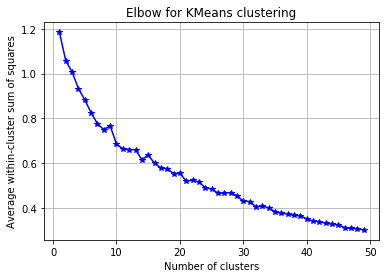

In [6]:
X = matrix[x_cols]
K = range(1, 50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]
# This function is used to calculate the distance between two input sets. 
# Different distance metric values can be obtained by specifying different ways of calculating the distance through the metric parameter.
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
# Calculate the smallest value from the sample to the cluster center in each clustering method.
dist = [np.min(D, axis=1) for D in D_k]
# Calculate the average of the sum of squared distances within a cluster.
avgWithnSS = [sum(d)/X.shape[0] for d in dist]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithnSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

The first cluster will explain the maximum variance of the marginal return drop as each new cluster is added. The new cluster will cause a considerable drop in the boundary, and the elbow is just at such a point, which is the optimal number of clusters. Therefore k=8.

### Explain the application of variance in the data matrix

Text(0.5, 1.0, 'Elbow for KMeans clustering')

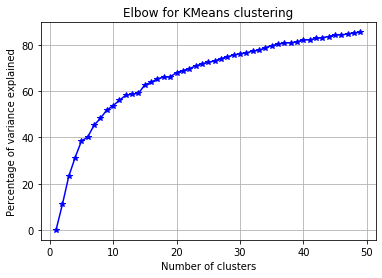

In [7]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
K = range(1, 50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D, axis=1) for D in D_k]
# Calculate the sum of the squares of the distance
wcss = [sum(d**2) for d in dist]
# 'pdist' calculate the Euclidean distance between X samples
tss = sum(pdist(X)**2)/X.shape[0]
# Subtract the intra-cluster sum of squares from the total sum of squares
bss = tss - wcss
kIdx = 10-1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

The gradient is smoothed from k=8, and the result obtained is consistent with the elbow rule.

### Draw Silouette coefficient score graph from data matrix

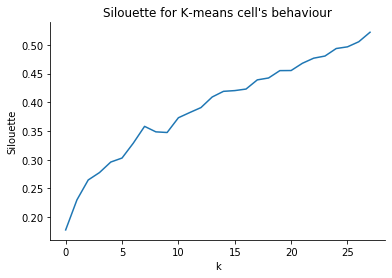

In [8]:
s = []
for n_clusters in range(2, 30):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    s.append(silhouette_score(X, labels, metric='euclidean'))
plt.plot(s)
plt.ylabel('Silouette')
plt.xlabel('k')
plt.title("Silouette for K-means cell's behaviour")
sns.despine()

Eventually we choose k=9.

In [9]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
cluster = KMeans(n_clusters=9, random_state=4)
matrix['cluster'] = cluster.fit_predict(X)
matrix.cluster.value_counts()

8    78
0    77
5    53
3    48
1    40
2    30
6    27
4    26
7    17
Name: cluster, dtype: int64

In [10]:
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:, 0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:, 1]
matrix = matrix.reset_index()
customer_clusters = matrix[['title', 'cluster', 'x', 'y']]
customer_clusters.head()

groups,title,cluster,x,y
0,"""Source Free"" Transfer Learning for Text Class...",8,0.615810,-0.060295
1,A Characterization of the Single-Peaked Single...,5,-0.756838,0.971322
2,"A Computational Method for (MSS,CoMSS) Partiti...",4,-0.287956,-0.216148
3,A Control Dichotomy for Pure Scoring Rules,5,-0.521295,0.570206
4,A Convex Formulation for Semi-supervised Multi...,1,0.198578,-0.129668


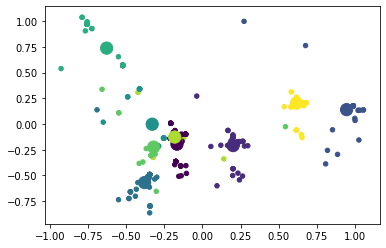

In [11]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))
# plot with chosen size and colour
plt.scatter(customer_clusters['x'], customer_clusters['y'], s=20, c=customer_clusters['cluster'])
plt.scatter(cluster_centers['x'], cluster_centers['y'], s=150, c=cluster_centers['cluster'])

In [12]:
customer_clusters.columns.name = None
# Concatenate data_train and customer_clusters with title as the primary key
df = data_train.merge(customer_clusters, on='title')
df.head()

,index,title,keywords,topics,groups,flags,cluster,x,y
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0,8,0.613870,0.245408
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0,8,0.615810,-0.060295
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0,8,0.615810,-0.060295
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0,5,-0.521295,0.570206
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0,0,-0.183192,-0.090091


### Create a function to draw a word cloud for each cluster

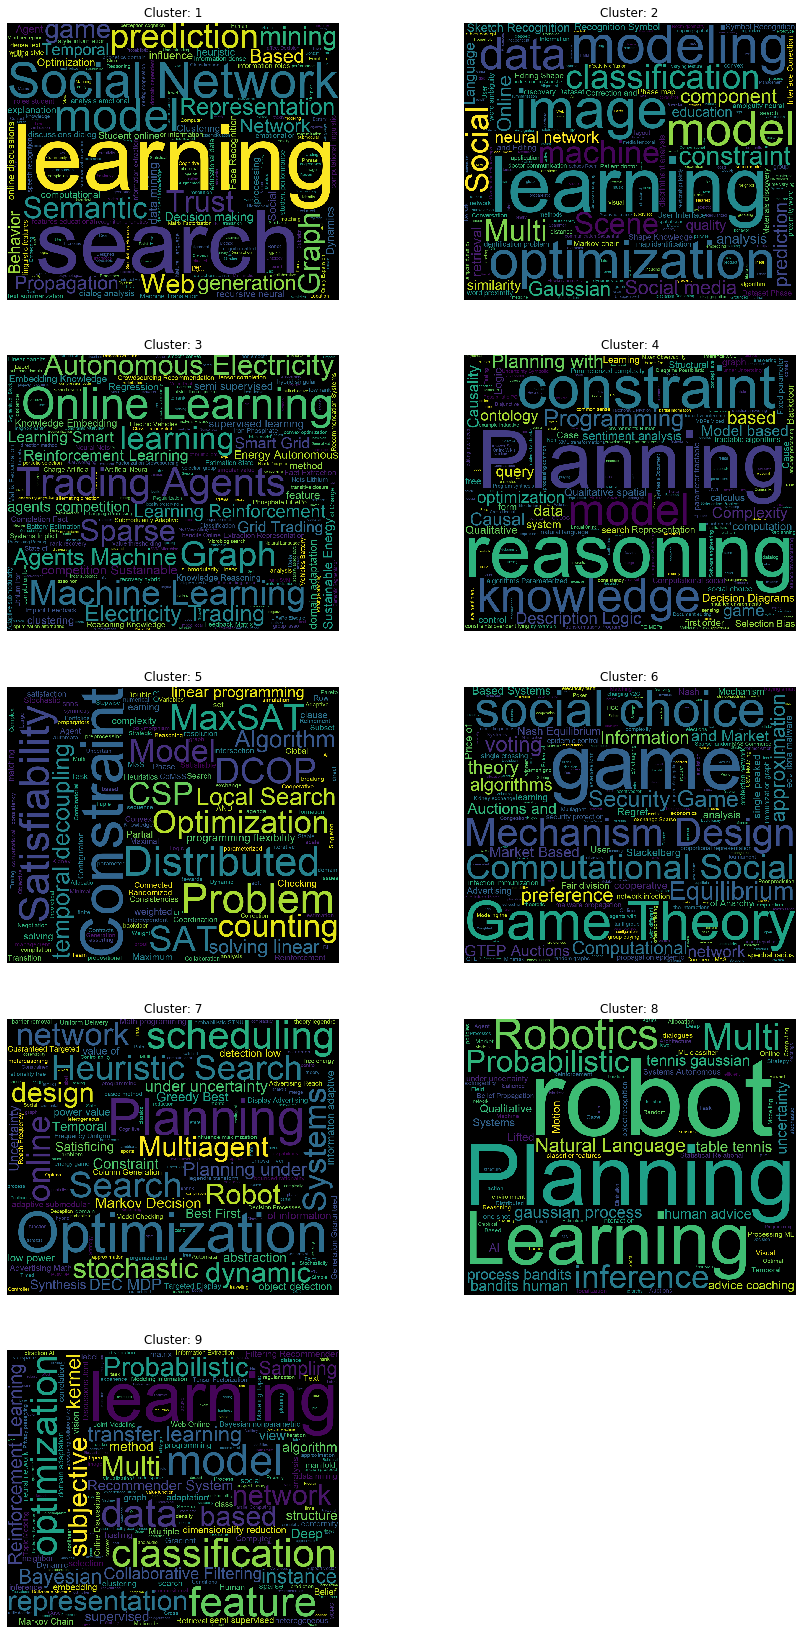

In [13]:
def wordcloud_object(word_string):
    FONT_ROOT = './fonts/'
    wordcloud = WordCloud(font_path=FONT_ROOT+'arial.ttf', stopwords=STOPWORDS, background_color='black', width=1200, height=1000).generate(' '.join(word_string))
    return wordcloud
# The 'pivot' parameter is a feature, through which you can get the bag of words, and then make the word cloud
def plot_wordcloud(df, clusters, pivot):
    fig = plt.figure(figsize=(15, 29.5))
    for cluster in range(clusters):
        List_ = []
        for x in df[df['cluster']==cluster][pivot]:
            try:
                List_.extend(x.split('\n'))
            except:
                pass
        if List_:
            ax = fig.add_subplot(5, 2, cluster+1)
            wordcloud = wordcloud_object(List_)
            plt.title('Cluster: %d' % (cluster+1))
            ax.imshow(wordcloud)
            ax.axis('off')
plot_wordcloud(df, cluster.n_clusters, 'keywords')

## Define methods to find complete keywords and single word formations for a given cluster

In [14]:
def perform_cluster_group_audit(df, clusters, term):
    for cluster in clusters:
        df_cluster = df[df['cluster'] == cluster]
        print('Cluster number: %d' % (cluster+1))
        keywords = list(df_cluster['keywords'])
        keywords = [keyword.split('\n') for keyword in keywords]
        keywords = [item for sublist in keywords for item in sublist]
        keywords = [keyword.lower() for keyword in keywords if term in keyword.lower()]
        keywords_freq = {x:keywords.count(x) for x in keywords}
        # 'reverse=True' descending order, the 'key' is the function to specify which item of the elements to be used for sorting, 
        # and the 'itemgetter' function provided by the 'operator' module is used to obtain the data in given dimensions of the object
        print(sorted(keywords_freq.items(), key=operator.itemgetter(1), reverse=True))
        print('\n')
perform_cluster_group_audit(df, [0, 8], 'search')
perform_cluster_group_audit(df, [3, 5], 'social')

Cluster number: 1
[('similarity search', 1), ('approximate nearest neighbor search', 1), ('web search personalization', 1), ('heuristic search', 1), ('real-time search', 1), ('agent-centered search', 1), ('hierarchical search', 1), ('parallel search', 1), ('entity search', 1), ('bounded suboptimal search', 1), ('real-time web search', 1), ('search snippets', 1), ('best-first search', 1), ('suboptimal heuristic search', 1), ('search result diversification', 1)]


Cluster number: 9
[('approximate near neighbor search', 2), ('cross-view similarity search', 2)]


Cluster number: 4
[('computational social choice', 4)]


Cluster number: 6
[('computational social choice', 16), ('social choice theory', 2), ('social decision schemes', 2), ('social welfare', 2), ('influencing social networks', 2), ('randomized social choice', 1)]




### Define function to draw cluster graph

In [15]:
def plot_results(X, Y_, means, covariances, index, title):
    # 'cycle() will repeat the incoming sequence indefinitely
    color_iter = itertools.cycle(['b', 'g', 'red', 'm', 'y', 'navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])
    splot = plt.subplot(2, 1, 1+index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        # np.linalg.eigh() used for matrix eigendecomposition in symmetric matrix
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # As long as one element in Y_ and i is equal, it can return true
        if not np.any(Y_ == i):
            continue
        temp = (Y_ == i)
        save_loc = []
        location = 0
        for i in temp:
            if i == True:
                save_loc.append(location)
            location += 1   
        plt.scatter(list(X.iloc[save_loc]['x']), list(X.iloc[save_loc]['y']), s=30, color=color)
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.+angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.xlim(0.0, 0.1)
    plt.ylim(-0.2, 1.2)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

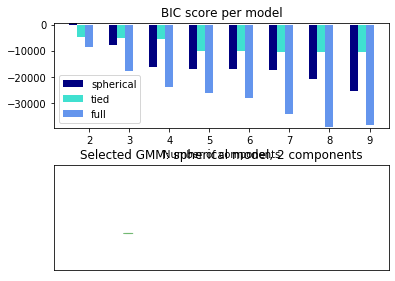

In [16]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
model_stats = []
n_components_range = range(2, 10)
# The Gaussian mixture model consists 'spherical', 'tied', 'full' variables to constrain the covariance of different cluster estimates
cv_types = ['spherical', 'tied', 'full']
for cv_type in cv_types:
    # In the case of each cluster number
    for n_components in n_components_range:
        # clustering in Gaussian mixture model
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type, random_state=0)
        gmm.fit(X)
        # BIC is the combination of likelihood function, parameters and sample size. 
        # We select the model with the smallest BIC value.
        model_stats.append({'name': '%s_%d' % (cv_type, n_components), 'model': gmm, 'bic': gmm.bic(X)})
bic = np.array([m_type['bic'] for m_type in model_stats])
# argmax returns the index of the largest number
best_gmm = model_stats[bic.argmax()]
# Save the name of the model
clf = best_gmm['model']
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue'])
bars = []
spl = plt.subplot(2, 1, 1)
# The i here means that cv_types is divided into i categories
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i-2)
    # Bar chart
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i+1)*len(n_components_range)], width=.2, color=color))
# Set the way the x-axis scale is expressed
plt.xticks(n_components_range)
plt.ylim([bic.min()*1.01-.01*bic.max(), bic.max()])
plt.title('BIC score per model')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
labels = clf.predict(X)
plot_results(df, labels, gmm.means_, gmm.covariances_, 1, 'Gaussian Mixture-%s' % gmm.converged_)
plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: %s model, %s components' % (best_gmm['name'].split('_')[0], best_gmm['name'].split('_')[1]))
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

### Visualize the clustering results of Gaussian mixture model

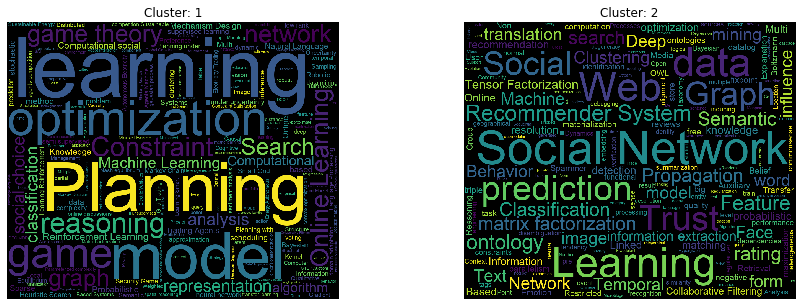

In [17]:
matrix['clusters'] = labels
matrix.clusters.value_counts()
customer_clusters.columns.name = None
temp = matrix[['title', 'clusters']]
customer_clusters = customer_clusters.merge(temp, on='title')
df = data_train.merge(customer_clusters, on='title')
df.drop('cluster',axis=1, inplace=True)
df.drop('x',axis=1, inplace=True)
df.drop('y',axis=1, inplace=True)
df.columns = ['index', 'title', 'keywords', 'topics', 'groups', 'flags', 'cluster']
plot_wordcloud(df, 3, 'keywords')

In [18]:
df.columns

Index(['index', 'title', 'keywords', 'topics', 'groups', 'flags', 'cluster'], dtype='object')

### Bayesian Gaussian Mixture Model

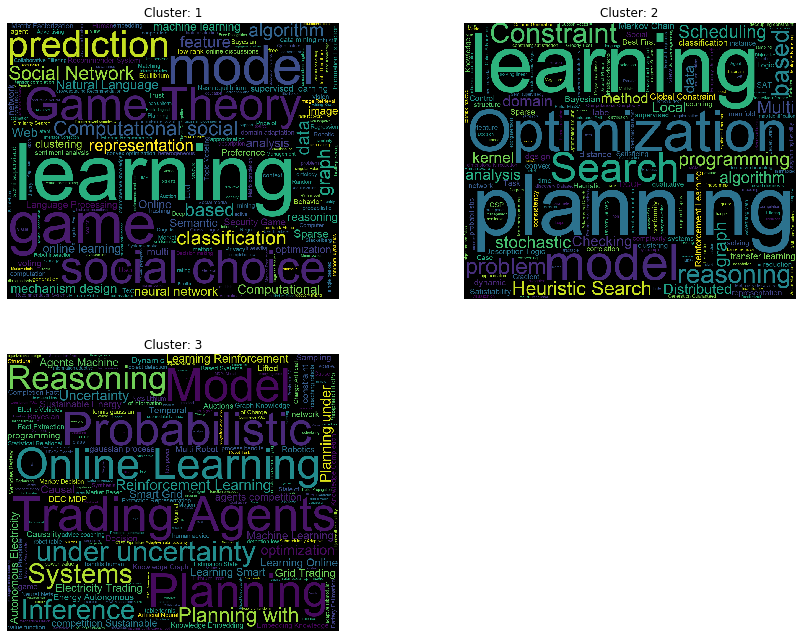

In [19]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
dpgmm = mixture.BayesianGaussianMixture(n_components=3, covariance_type='full', random_state=1).fit(X)
labels = dpgmm.predict(X)
matrix['clusters'] = labels
matrix.clusters.value_counts()
customer_clusters.columns.name = None
temp = matrix[['title', 'clusters']]
customer_clusters = customer_clusters.merge(temp, on='title')
df = data_train.merge(customer_clusters, on='title')
df.drop('cluster',axis=1, inplace=True)
df.drop('x',axis=1, inplace=True)
df.drop('y',axis=1, inplace=True)
df.drop('clusters_x',axis=1, inplace=True)
df.columns = ['index', 'title', 'keywords', 'topics', 'groups', 'flags', 'cluster']
plot_wordcloud(df, 3, 'keywords')

Cluster 1: In-depth papers discussing game theory and social media analysis
Cluster 2: An in-depth paper discussing model optimization and model learning
Cluster 3: Topics related to linear programming, knowledge graphs, and inference-based models

## Reference
https://github.com/wzy6642/Machine-Learning-Case-Studies